In [1]:
#pip install socceraction

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage

import tqdm
import os

import socceraction.spadl as spadl
from socceraction.data.statsbomb import StatsBombLoader

In [3]:
#classifiers
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [4]:
# path to the STATSBOMB free data
datafolder = r'C:/Users/frede/Documents/FootballAnalyst/Statsbomb/open-data-master/data'
SBL = StatsBombLoader(root=datafolder, getter="local")

In [5]:
# View all available competitions from STATSBOMB
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "Women's World Cup"}

In [6]:
# For this challenge I've chosen to use Euro2021 data
selected_competitions = competitions[competitions.competition_name == "UEFA Euro"]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
38,43,55,UEFA Euro,Europe,male,2020


In [7]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games.head()

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3788753,43,55,Group Stage,2,2021-06-16 15:00:00,1835,796,0,1,Saint-Petersburg Stadium,Danny Desmond Makkelie
1,3788765,43,55,Group Stage,3,2021-06-20 18:00:00,773,909,3,1,Bakı Olimpiya Stadionu,Slavko Vinčić
2,3795107,43,55,Quarter-finals,5,2021-07-02 21:00:00,782,914,1,2,Allianz Arena,Slavko Vinčić
3,3795221,43,55,Semi-finals,6,2021-07-07 21:00:00,768,776,2,1,Wembley Stadium,Danny Desmond Makkelie
4,3795506,43,55,Final,7,2021-07-11 21:00:00,914,768,1,1,Wembley Stadium,Björn Kuipers


In [8]:
events = pd.concat([
    SBL.events(row.game_id)
    for row in games.itertuples()
])
events.head()

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
0,3788753,9427b18a-6b10-411f-90da-3d6240b80c71,1,1835,NaN,35,Starting XI,1,1900-01-01 00:00:00.000,0,...,Finland,0.000000,"{'tactics': {'formation': 352, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
1,3788753,542c58bf-5c6c-43ca-9d8d-e086c7f08aaf,1,796,NaN,35,Starting XI,2,1900-01-01 00:00:00.000,0,...,Russia,0.000000,"{'tactics': {'formation': 3421, 'lineup': [{'p...",[],NaN,NaN,NaN,NaN,False,False
2,3788753,a0dfe8a0-a0b9-443e-89e3-a8ba6596fa33,1,1835,NaN,18,Half Start,3,1900-01-01 00:00:00.000,0,...,Finland,0.000000,{},[c7156352-f4b7-4140-aa51-6e26fd019a11],NaN,NaN,NaN,NaN,False,False
3,3788753,c7156352-f4b7-4140-aa51-6e26fd019a11,1,796,NaN,18,Half Start,4,1900-01-01 00:00:00.000,0,...,Russia,0.000000,{},[a0dfe8a0-a0b9-443e-89e3-a8ba6596fa33],NaN,NaN,NaN,NaN,False,False
4,3788753,94dbc5c3-ef37-445e-9154-3d9f9ea9245d,1,796,6299.0,30,Pass,5,1900-01-01 00:00:00.490,0,...,Russia,1.373215,"{'pass': {'recipient': {'id': 31917, 'name': '...",[c0935bbe-3eb4-4a21-9eee-45f380d1f26d],Aleksey Miranchuk,18.0,Right Attacking Midfield,"[60.0, 40.0]",False,False


In [9]:
events.columns

Index(['game_id', 'event_id', 'period_id', 'team_id', 'player_id', 'type_id',
       'type_name', 'index', 'timestamp', 'minute', 'second', 'possession',
       'possession_team_id', 'possession_team_name', 'play_pattern_id',
       'play_pattern_name', 'team_name', 'duration', 'extra', 'related_events',
       'player_name', 'position_id', 'position_name', 'location',
       'under_pressure', 'counterpress'],
      dtype='object')

In [10]:
shots = events.loc[events['type_name']=='Shot']
shots.head()

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
49,3788753,91f2f8aa-4ee8-4593-97a6-1a7862a7cca5,1,796,20845.0,16,Shot,50,1900-01-01 00:00:29.166,0,...,Russia,0.257779,"{'shot': {'statsbomb_xg': 0.036601424, 'end_lo...","[4e5ffb57-b5c8-44f0-b33f-8d21dfab5a77, 76e2a3f...",Magomed Ozdoev,9.0,Right Defensive Midfield,"[99.9, 48.2]",False,False
430,3788753,0bb2daca-ab0b-497c-ac59-3cc559be6fb7,1,796,20845.0,16,Shot,431,1900-01-01 00:09:42.014,9,...,Russia,0.573803,"{'shot': {'statsbomb_xg': 0.23458281, 'end_loc...",[defbd524-173b-49cd-aaa3-f2c279e2f4db],Magomed Ozdoev,9.0,Right Defensive Midfield,"[109.6, 49.0]",False,False
855,3788753,1215b0dc-81fb-4416-b9a6-0faf150a4e8d,1,1835,9725.0,16,Shot,856,1900-01-01 00:19:53.988,19,...,Finland,0.033893,"{'shot': {'statsbomb_xg': 0.28013524, 'end_loc...","[609291e4-de5e-421f-b4b7-33564421beff, a9266da...",Joel Pohjanpalo,24.0,Left Center Forward,"[107.2, 45.3]",False,False
864,3788753,1ce72d1b-a7c5-4eb3-965f-61621b798f35,1,1835,26939.0,16,Shot,865,1900-01-01 00:20:38.796,20,...,Finland,1.258832,"{'shot': {'statsbomb_xg': 0.014892562, 'end_lo...","[7f642e88-7ab3-4eb3-bcd4-386010e0a6dd, d28ee04...",Joona Toivio,3.0,Right Center Back,"[110.9, 29.6]",True,False
1081,3788753,7aa54ce6-106a-4e26-9fb1-77aa0d76f793,1,796,5195.0,16,Shot,1082,1900-01-01 00:29:01.200,29,...,Russia,0.077448,"{'shot': {'statsbomb_xg': 0.13386948, 'end_loc...","[1c9be059-8657-4109-a7be-47477154deb4, 31eeda3...",Artem Dzyuba,23.0,Center Forward,"[114.8, 42.1]",True,False


In [11]:
pd.DataFrame.from_dict(shots.extra.iloc[2])

,shot
body_part,"{'id': 40, 'name': 'Right Foot'}"
end_location,"[108.1, 44.8]"
freeze_frame,"[{'location': [105.9, 32.3], 'player': {'id': ..."
key_pass_id,8c91e4ea-c7ec-445c-b7da-1e886a87a594
outcome,"{'id': 96, 'name': 'Blocked'}"
statsbomb_xg,0.280135
technique,"{'id': 93, 'name': 'Normal'}"
type,"{'id': 87, 'name': 'Open Play'}"


In [12]:
shots = pd.concat([shots.drop(['extra'], axis=1), shots['extra'].apply(pd.Series)], axis=1)
shots = pd.concat([shots.drop(['shot'], axis=1), shots['shot'].apply(pd.Series)], axis=1)
shots = pd.concat([shots.drop(['outcome'], axis=1), shots['outcome'].apply(pd.Series)], axis=1)

In [13]:
shots = shots[['location','name']]
shots = shots.reset_index(drop=True)

In [14]:
shots.head()

,location,name
0,"[99.9, 48.2]",Blocked
1,"[109.6, 49.0]",Off T
2,"[107.2, 45.3]",Blocked
3,"[110.9, 29.6]",Off T
4,"[114.8, 42.1]",Blocked


In [15]:
shots.loc[shots['name'] =='Goal']

,location,name
7,"[108.7, 50.5]",Goal
30,"[99.8, 28.0]",Goal
37,"[98.4, 40.1]",Goal
55,"[97.4, 48.6]",Goal
59,"[105.1, 44.4]",Goal
...,...,...
1248,"[107.6, 37.7]",Goal
1254,"[109.2, 45.7]",Goal
1260,"[102.5, 49.2]",Goal
1277,"[113.3, 40.4]",Goal


## Plotting every shot of the tournament

In [16]:
def draw_half_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([60,0], width = 60, height = 80, fill = False)
    #Right Penalty Area
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)

    #Right 6-yard Box
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = Arc((60,40),width = 8.1, height = 8.1, angle=0,theta1=270,theta2=90,color="black")
    centreSpot = plt.Circle((60,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, RightPenalty, RightSixYard, centreCircle, centreSpot, rightPenSpot, rightArc]
    for i in element:
        ax.add_patch(i)

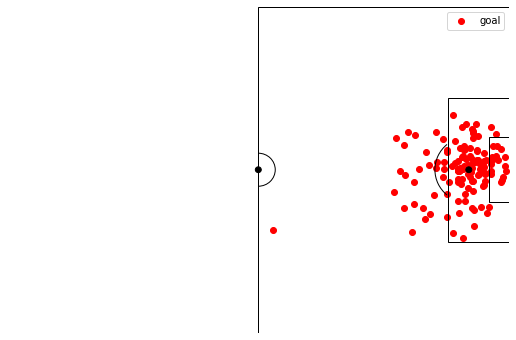

In [17]:
#Plotting every shot that lead to a GOAL
fig=plt.figure()
fig.set_size_inches(9, 6)
ax=fig.add_subplot(1,1,1)
draw_half_pitch(ax)
plt.axis('off')
# draw the scatter plot for goals
x_coord_goal = [location[0] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] == "Goal"]
y_coord_goal = [location[1] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] == "Goal"]

# put the two scatter plots on to the pitch
ax.scatter(x_coord_goal, y_coord_goal, c = 'red', label = 'goal')
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

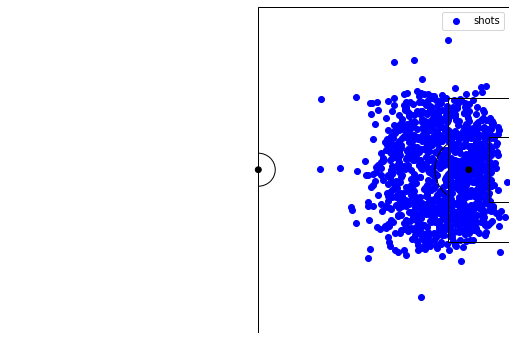

In [18]:
#Plotting every shot that didn't lead to a GOAL
fig=plt.figure()
fig.set_size_inches(9, 6)
ax=fig.add_subplot(1,1,1)
draw_half_pitch(ax)
plt.axis('off')
# shots that end up with no goal
x_coord = [location[0] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] != "Goal"]
y_coord = [location[1] for i, location in enumerate(shots["location"]) if shots.iloc[i]['name'] != "Goal"]

ax.scatter(x_coord, y_coord, c = 'blue', label = 'shots')
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

In [19]:
(shots['location'][0])[0]

99.9

In [20]:
shots

,location,name
0,"[99.9, 48.2]",Blocked
1,"[109.6, 49.0]",Off T
2,"[107.2, 45.3]",Blocked
3,"[110.9, 29.6]",Off T
4,"[114.8, 42.1]",Blocked
...,...,...
1284,"[95.5, 31.6]",Off T
1285,"[99.4, 48.8]",Blocked
1286,"[94.9, 40.8]",Blocked
1287,"[104.5, 32.4]",Blocked


In [21]:
shots.loc[(shots.name != 'Goal'),'name']=0
shots.loc[(shots.name == 'Goal'),'name']=1

In [22]:
shots_xy = pd.DataFrame(shots['location'].tolist(), columns=['x', 'y'])
shots = pd.concat([shots, shots_xy], axis=1)
shots = shots[["x", "y", "name"]]
shots.head()

,x,y,name
0,99.9,48.2,0
1,109.6,49.0,0
2,107.2,45.3,0
3,110.9,29.6,0
4,114.8,42.1,0


In [23]:
shots.isna().any().any()

False

### Modelling

In [24]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


In [25]:
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

In [26]:
X = shots.iloc[:, :-1]
y = shots.iloc[:, -1]
y=y.astype('int')

In [28]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=0)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1224, 2), (65, 2), (1224,), (65,))

In [33]:
acc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

In [34]:
for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

<ipython-input-34-e38555639db5>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-34-e38555639db5>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-34-e38555639db5>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-34-e38555639db5>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-34-e38555639db5>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-i

<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='Accuracy', ylabel='Classifier'>

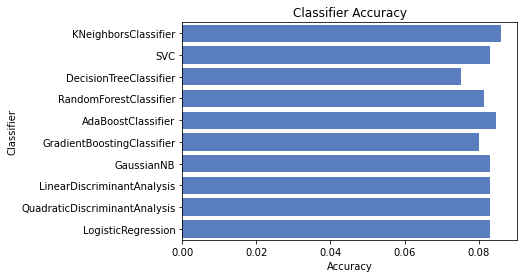

In [37]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

#### KNeighborsClassifier had the best accuracy for predicting a shot based on its x,y coordinates

In [ ]:
#We could now use the KNeighborsClassifier to predict the outcome of any shot
#It would now be interesting to add other variables to our model such as the distance to the goal and
#the angle of the shot, or even if it was a header or not...